In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [34]:
from glob import iglob, glob

In [3]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
prepro = transforms.Compose(
    [
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]
)
prepro_val = transforms.Compose(
    [transforms.Resize((350, 350)), transforms.ToTensor(), normalize]
)

In [43]:
from PIL import Image
import os.path

In [61]:
class folderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.transform = transform
        self.class_to_idx = {}
        self.data = []
        for i, folder in enumerate(glob(os.path.join(root + '*'))):
            self.class_to_idx[folder.split("/")[-1]] = i
            for image in iglob(os.path.join(folder, "*.jpg")):
                self.data.append( (image, i) )
        print(self.class_to_idx)
        
    def __getitem__(self, index):
        return self.transform(Image.open(self.data[index][0]).convert("RGB")), self.data[index][1]
    
    def __len__(self):
        return len(self.data)

In [62]:
#trainset = datasets.ImageFolder("/data/porn/data/train/", transform=prepro)
trainset = folderDataset("/data/porn/data/train/", transform=prepro)

{'sexy': 0, 'porn': 1, 'drawings': 2, 'hentai': 3, 'neutral': 4}


In [63]:
valset = folderDataset("/data/porn/data/test/", transform=prepro_val)

{'sexy': 0, 'porn': 1, 'drawings': 2, 'hentai': 3, 'neutral': 4}


In [64]:
train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8,pin_memory=True)
val_loader = DataLoader(valset, batch_size=256, shuffle=True, num_workers=8,pin_memory=True)

In [65]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 5)

In [66]:
# moving model to gpu if available
device = torch.device("cuda:1")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

In [67]:
##### defining the number of epochs
epochs = 2
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=5)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [68]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [69]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [70]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

In [71]:
@trainer.on(Events.ITERATION_STARTED(every=1))
def call_every(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

In [72]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['drawing','hentai','neutral','porn','sexy']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [73]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

In [ ]:
trainer.run(train_loader, max_epochs=epochs)

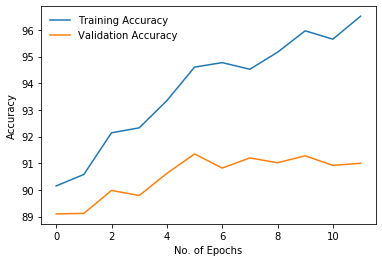

In [13]:
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

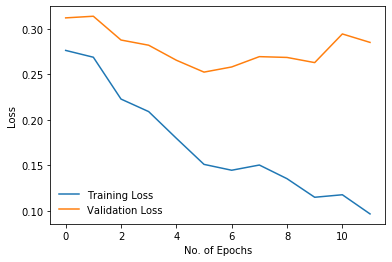

In [14]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [17]:
# loading the saved model
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pth' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print("Model Loaded")

Model Loaded


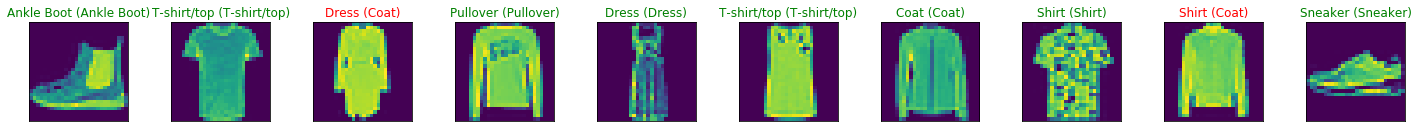

In [18]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(val_loader)
images, labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference 
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))